# Inter-Panel Compound Figure Forgery Generator

**Description**

This notebook describes how to create Inter-Panel Compound Figures, in which two
of its panels have duplicated content.

## Types of forgeries -- Inter-Panel:
1- Simple Copy:\
    Copy an image twice on two different panels.\
    
2 - Panel Copy-Move with Retouching :\
    This method is very similar to the previous one, increasing the level of retouching between the duplicates panels.
    
3- Overlap:\
    This method crops an image in two pieces that overlap, then\
    it insert these two pieces on different panels of the image. To increase difficulty, we select the most similar images from our dataset
    to be part of the others panels
    
4- Splicing:\
    This method copies n objects from a donor image and insert them on a host image.
    After all, the host and the donor are insert in the same compound figure.
    
    
    
To select some similar images and increase the difficult for spot duplicate images,
during this notebook we use the module imagededup. ( Make sure to install it before running this notebook):\
`pip install imagededup`
----

Author: João Phillipe Cardenuto\
Email: phillipe.cardenuto@ic.unicamp.br\
August, 2022
----





## Import paths

In [1]:
# Insert here the path of each component
LIB_PATH = '../'
TEMPLATES_BIO_PATH = '../templates_json/Mc'
TEMPLATES_MIX_PATH = '../templates_json/Mix'
TEMPLATES_WB_PATH = '../templates_json/Wb'


In [2]:
# Including path to forgery_lib dataset on the notebook
import sys
sys.path.append(LIB_PATH)

# Import common libraries
from forgery_lib import InterPanelForgery
import os, json, copy, random
from PIL import Image
from glob import glob
from random import randint
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd

## Read source dataset with all biological images 

In [3]:
# Reads the csv file and insert all images aspect ratio on that
def get_img_ar(img_path):
    
    img = np.array(Image.open(img_path))
    return img.shape[0] / img.shape[1]

dataset_dataframe = pd.read_csv('../datasetSrc.csv')

In [4]:
# Fix dataset source image paths
DATASET_PATH = '../'
dataset_dataframe['dataPath'] = DATASET_PATH + dataset_dataframe['dataPath']
dataset_dataframe['dataGTPath'] = DATASET_PATH + dataset_dataframe['dataGTPath']

In [5]:
dataset_dataframe.subset_tag.value_counts()

wblot      1009
obj_map     850
gray        444
pmc         382
overlap     165
color       108
Name: subset_tag, dtype: int64

In [6]:
dataset_dataframe.columns

Index(['class', 'DatasetRef', 'License', 'Link', 'ObjectMaskPath',
       'RealDataPath', 'subset_tag', 'dataGTPath', 'dataPath', 'AR'],
      dtype='object')

## Read Templates and fonts

In [7]:
# Loading templates and fonts
bio_templates = sorted(glob(f"{TEMPLATES_BIO_PATH}/*") + glob(f"{TEMPLATES_MIX_PATH}/*"))
wb_templates = sorted(glob(f"{TEMPLATES_WB_PATH}/*") + glob(f"{TEMPLATES_MIX_PATH}/*"))
fonts = glob(f"{LIB_PATH}/forgery_lib/figure/fonts/*")

----

# 1- Simple copy

### Function to generate the operation to be applied on the forgery panel

In [8]:
def set_simple_copy_operation(rot):
    """
    This function randomly selects the value for rotation, flippingm and brighteness, 
    to be applied in the copy_moving.
    """
    
    if rot=='flip':
        operations = { 'flip': True,
                      'brightness' : randint(0,30) }
    elif rot=='rotation180':
        operations = { 
                      'rotation': 'ROTATE_180',
                      'brightness' : randint(0,30) }
    elif rot=='rotation90':
        operations = { 'flip': False,
                      'rotation': random.choice([ 'ROTATE_90_CLOCKWISE', 'ROTATE_90_COUNTERCLOCKWISE']),
                      'brightness' : randint(0,30) }
    elif rot=='flip90':
        operations = { 'flip': True,
                      'rotation': random.choice([ 'ROTATE_90_CLOCKWISE', 'ROTATE_90_COUNTERCLOCKWISE']),
                      'brightness' : randint(0,30) }
  
    else:
        operations = { 'flip':False,
                      'rotation': None,
                      'brightness' : randint(0,30) 
                     }
    return operations

In [9]:

def get_local_dataset(dataPath, data_class):
    """
    This function selectes a local dataset for an input image (that will participate the forgery)
    removing it from the real dataset to avoid any contamination during the forgery procedure
    """
    # Creates a copy of the dataset
    local_dataframe = dataset_dataframe.copy()
    local_dataframe.drop(local_dataframe.loc[local_dataframe['dataPath']==dataPath].index, inplace=True)
    
    return local_dataframe
 

Given a src_image, we need to find a template that has at lest two panels with AR of src_image
then we need to see if this the dataset have figure that fit the template

### Testing our function and data

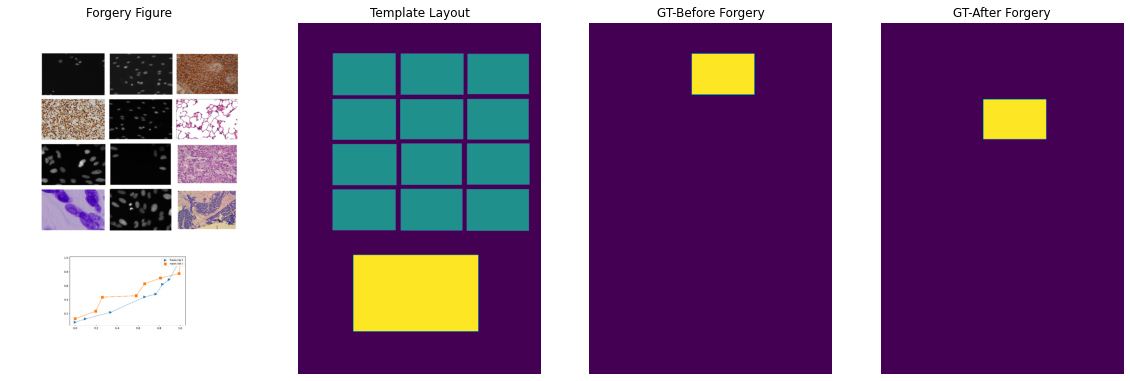

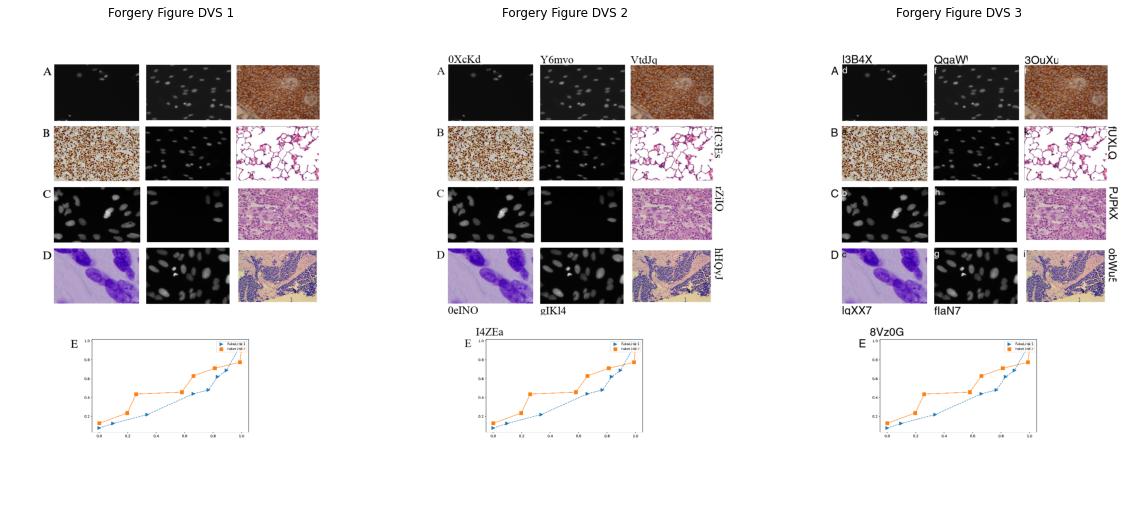

FORGERY METADATA


{'forgery_info': {'class': 'Microscopy',
  'function_name': 'simple_copy',
  'args': {'operations': {'flip': True, 'brightness': 19}},
  'figure_type': 'inter-panel',
  'modality': 'duplication'},
 'figure_annotations': {'height': 1280,
  'width': 884,
  'template': '../templates_json/Mc/075_gt.json',
  1: {'bbox': {'x0': 127, 'x1': 355, 'y0': 114, 'y1': 266},
   'class': 'Microscopy',
   'image_id': '../srcDataset/00500.png'},
  2: {'bbox': {'x0': 374, 'x1': 602, 'y0': 115, 'y1': 264},
   'class': '__FORGERY__',
   'image_id': '../srcDataset/00002.png'},
  3: {'bbox': {'x0': 617, 'x1': 840, 'y0': 116, 'y1': 262},
   'class': 'Microscopy',
   'image_id': '../srcDataset/01755.jpg'},
  4: {'bbox': {'x0': 126, 'x1': 356, 'y0': 280, 'y1': 428},
   'class': 'Microscopy',
   'image_id': '../srcDataset/01823.jpg'},
  5: {'bbox': {'x0': 616, 'x1': 839, 'y0': 280, 'y1': 427},
   'class': 'Microscopy',
   'image_id': '../srcDataset/01550.jpg'},
  6: {'bbox': {'x0': 372, 'x1': 601, 'y0': 281, 'y1

In [10]:
# Function test
#####################
# Loading data
biologica_data = dataset_dataframe[ dataset_dataframe['subset_tag'].isin(['obj_map','gray','color','pmc'])]
# image query
query =  biologica_data.iloc[1]

# Get local dataset with ours constrains
local_dataset = get_local_dataset(query['dataPath'],query['class'])

# Loading data
forgery_info = {
    'function_name' : 'simple_copy',
    'args' : {'operations': set_simple_copy_operation(rot='flip')},
    'forgery_class': 'Microscopy'
}

tampering = InterPanelForgery(local_dataset, forgery_info, query, template_dataset=bio_templates)

# Plot Result
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1); plt.imshow(tampering.figure);plt.title("Forgery Figure");plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(tampering.template_image);plt.title("Template Layout");plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(tampering.gt_after_forgery);plt.title("GT-Before Forgery");plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(tampering.gt_before_forgery);plt.title("GT-After Forgery");plt.axis('off')
plt.show()


plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1); plt.imshow(tampering.apply_verbose_text(tampering.figure, 1,random.choice(fonts)));plt.title("Forgery Figure DVS 1");plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(tampering.apply_verbose_text(tampering.figure, 2,random.choice(fonts)));plt.title("Forgery Figure DVS 2");plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(tampering.apply_verbose_text(tampering.figure, 3,random.choice(fonts)));plt.title("Forgery Figure DVS 3");plt.axis('off')
plt.show()
print("FORGERY METADATA")
tampering.get_forgery_metadata()

### Dumps the forgery in a Test Directory

In [11]:
# Insert the output path for the result figure and annotations
_OUTPUT_PATH = 'test/simple_copy/'

def generate_duplicate_panels(query):
    """
    This function wraps all activites of a simple-copy move forgery
    saving all annotations and related figures gerated related to this
    procedure
    """
    if query['class'] == 'Microscopy':
        templates = bio_templates
    else:
        templates = wb_templates
    # Apply the simple-copy foregery with the forgery panel trasnformed 
    # by each operation
    for operation in ['flip','flip90','rotation180', 'rotation90','none']:
        # Local_dataset:
        local_dataset = get_local_dataset(query['dataPath'],query['class'])
        
        # Apply the fuction until the algorithm be able to generate a forgery
        # or it reaches the limit of 10 attempts
        attempts = 10
        while attempts:
            
            # Loading forgery infos
            forgery_info_args =  {'operations': set_simple_copy_operation(rot=operation)}
            forgery_info = {
                            'function_name' : 'simple_copy',
                            'args' : forgery_info_args.copy(),
                            'multi_panel': True,
                            'forgery_class': query['class']
                            }
            
            try:
                tampering = InterPanelForgery(local_dataset, forgery_info,
                                             templates , query)
            except:
                attempts-=1
                continue
             # We only consider a successfuly forgery if the 
            # groundtruth of the result figure has at least 500 pixels
            # trasnformed
            if tampering.forgery_image_gt.sum() > 500:
                break
            attempts-=1

        # Do Not create a output path if all attempts failed
        if attempts == 0:
            continue

        # At this point the forgery was successfuly done
        # Create outpath, if needed
        index_name = os.path.basename(query['dataPath'])
        index_name = index_name[:index_name.rfind(".")]
        
        local_output_path = f"{_OUTPUT_PATH}/{operation}/{index_name}"
        os.makedirs(local_output_path, exist_ok=True)

        # Save pristine image, forgery image, background map region, object map region
        Image.fromarray(tampering.pristine_image).save(f"{local_output_path}/panel_pristine.png")
        Image.fromarray(tampering.forgery_image).save(f"{local_output_path}/panel_forgery.png")
        Image.fromarray(tampering.pristine_gt).save(f"{local_output_path}/panel_pristine_map.png")
        Image.fromarray(tampering.forgery_image_gt).save(f"{local_output_path}/panel_forgery_map.png")
        Image.fromarray(tampering.figure).save(f"{local_output_path}/figure.png")
        Image.fromarray(tampering.apply_verbose_text(tampering.figure, 1,random.choice(fonts))).save(f"{local_output_path}/figure_v1.png")
        Image.fromarray(tampering.apply_verbose_text(tampering.figure, 2,random.choice(fonts))).save(f"{local_output_path}/figure_v2.png")
        Image.fromarray(tampering.apply_verbose_text(tampering.figure, 3,random.choice(fonts))).save(f"{local_output_path}/figure_v3.png")
        Image.fromarray(tampering.figure_groundtruth_forgery).save(f"{local_output_path}/figure_forgery_gt.png")
        Image.fromarray(tampering.figure_groundtruth_pristine).save(f"{local_output_path}/figure_pristine_gt.png")

        # Save Annotations
        with open(f"{local_output_path}/annotations.json", 'w') as fp:
            json.dump(tampering.get_forgery_metadata(),fp)

### Create figure with forgery on the biological class

In [11]:
# Uncomment the following lines to create your own dataset
#biologica_data = dataset_dataframe[ dataset_dataframe['subset_tag'].isin(['obj_map','gray','color','pmc'])]
#generate_duplicate_panels(biologica_data.iloc[0])

# 2 - Overlap Function

The overlap function creates two panels from a single image that is cropped in two different parts with some sort of overlap

In [12]:
# We are using the libarry Imagededup for finding similar images
# https://idealo.github.io/imagededup/
from imagededup.methods import CNN
os.environ['HDF5_USE_FILE_LOCKING'] ='FALSE'

### Function to generate the operation to be applied on the forgery panel

In [13]:
def set_overlap_operations(crop_type1 ):
    """
    Select two possibles operations to apply the overlap function
    """
    CROP_TYPES = ['top_right', 'top_left', 'center']
    ROT_TYPES = [ 'ROTATE_180' , 'ROTATE_90_CLOCKWISE', 
                            'ROTATE_90_COUNTERCLOCKWISE']
    
    if crop_type1 in CROP_TYPES:
        CROP_TYPES.remove(crop_type1)
        
    operation2 = {
                'crop_type': random.choice(CROP_TYPES) ,
                'flip': bool(randint(0,1)),
                'rotation': random.choice(ROT_TYPES),
                'brightness': randint(10,30),

            }
    return operation2

### Arrange data to group similar data

In [23]:
# In order to select similar data, we copy all data to a temp dir
# and generates its encoding
import shutil
import tempfile
from pathlib import Path
import os
with tempfile.TemporaryDirectory(dir='.') as tmpdir:
    os.makedirs(tmpdir, exist_ok=True)
    for index,row in dataset_dataframe.iterrows():
        src = row['dataPath']
        
        dest = tmpdir + os.sep + "".join(src.split('srcDataset/')[1:])
        shutil.copy(src, dest)

    cnn_enconder = CNN()
    imgs_encoding = cnn_enconder.encode_images(tmpdir)
    # similar data is a dictonary with each similar image from dataset_dataframe
    similar_data = cnn_enconder.find_duplicates(encoding_map=imgs_encoding,
                         min_similarity_threshold=0.5, scores=True )


2022-08-13 18:50:41.355704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 18:50:41.355758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-13 18:51:11.716243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 18:51:11.716288: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 18:51:11.716324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sms05): /proc/driver/nvidia/version does not exist
2022-08-13 18:51:13,324: INFO Initialized: MobileNet pretrained on Imag

47/47 [==============================] - 69s 1s/step


2022-08-13 18:52:23,089: INFO End: Image encoding generation
2022-08-13 18:52:23,098: INFO Start: Calculating cosine similarities...
2022-08-13 18:52:23,214: INFO End: Calculating cosine similarities.


### Get a specific dataset for each image, avoiding any contamination with similar images

In [28]:
def get_similar_dataset(query_id):
    """
    This function selects a local dataset for an input image that will participate to the forgery.
    Whenever possible, We included the most similar images on the dataset, using the library imagededup. 
    """
    
    # Get local western blot data
    local_dataframe = dataset_dataframe.copy()
    wb_data = local_dataframe[ local_dataframe['subset_tag'].isin(['wblot'])]
    
    ####################################
    # Get bio data similar to the overlap
    ###################################
    # Sort by similarity to query
    images_similar_to_query = sorted(similar_data[query_id], key=lambda x: x[1], reverse=True)
    # Insert path srcDataset in similar
    dataPath_similar_to_query = [f'{DATASET_PATH}/srcDataset/{d[0]}' for d in images_similar_to_query]
    images_similar_to_query = { 'dataPath': dataPath_similar_to_query,
                                'score':  [d[1] for d in images_similar_to_query]}
    images_similar_to_query = pd.DataFrame.from_dict(images_similar_to_query)
    
    # Get bio_dataset that do not inlcude overlap images
    local_bio_data = dataset_dataframe.copy()
    local_bio_data = local_bio_data[ local_bio_data['subset_tag'].isin(['obj_map','gray','color','pmc'])]
    # Make an inner-join between local_bio_data and images_similar_to_query and sort the values by score
    local_bio_data = local_bio_data.merge(images_similar_to_query).sort_values(by='score',ascending=False)

    # get top 50
    local_bio_data = local_bio_data.iloc[:50]
    
    if len(local_bio_data) < 50:
        # including more data to get into 50
        more_data = dataset_dataframe.copy()
        more_data = more_data[ more_data['subset_tag'].isin(['obj_map','gray','color','pmc'])]

        more_data = more_data.sample(100)
        more_data['score'] = 0
        local_bio_data = local_bio_data.append(more_data)
        local_bio_data = local_bio_data.sort_values(by='score',ascending=False)
        local_bio_data = local_bio_data.drop_duplicates(subset=['dataPath'])
        local_bio_data = local_bio_data.iloc[:50]
    
    local_bio_data = local_bio_data.append( wb_data)
    return local_bio_data



### Test function

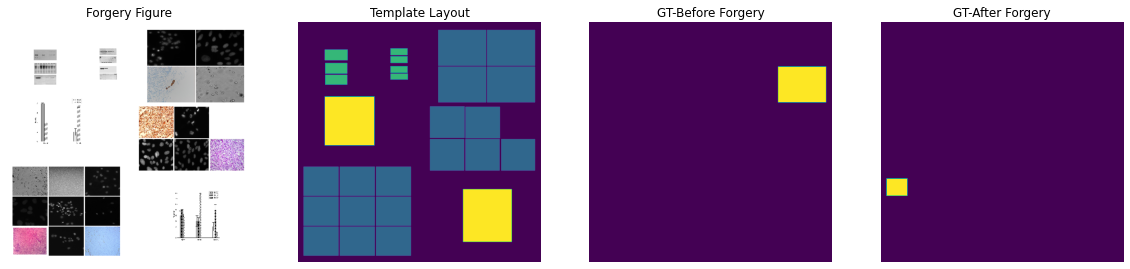

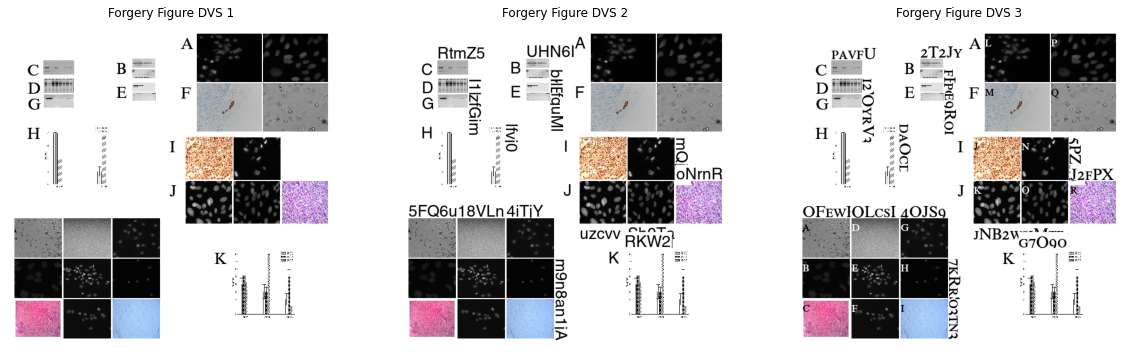

FORGERY METADATA


{'forgery_info': {'class': 'Microscopy',
  'function_name': 'overlap_forgery',
  'args': {'operation1': {'crop_type': None},
   'operation2': {'crop_type': 'top_right',
    'flip': False,
    'rotation': 'ROTATE_180',
    'brightness': 10}},
  'figure_type': 'inter-panel',
  'modality': 'duplication'},
 'figure_annotations': {'height': 609,
  'width': 617,
  'template': '../templates_json/Mix/147_gt.json',
  1: {'bbox': {'x0': 356, 'x1': 478, 'y0': 20, 'y1': 111},
   'class': 'Microscopy',
   'image_id': '../srcDataset/00103.png'},
  2: {'bbox': {'x0': 480, 'x1': 602, 'y0': 20, 'y1': 111},
   'class': 'Microscopy',
   'image_id': '../srcDataset/00843.png'},
  3: {'bbox': {'x0': 235, 'x1': 278, 'y0': 67, 'y1': 84},
   'class': 'WesternBlot',
   'image_id': '../srcDataset/02669.tif'},
  4: {'bbox': {'x0': 68, 'x1': 126, 'y0': 70, 'y1': 97},
   'class': 'WesternBlot',
   'image_id': '../srcDataset/02465.jpg'},
  5: {'bbox': {'x0': 235, 'x1': 278, 'y0': 87, 'y1': 104},
   'class': 'Western

In [41]:
# Function test
#####################
# Loading data
overlap_data = dataset_dataframe[ dataset_dataframe['subset_tag'].isin(['overlap'])]
# image query
query =  overlap_data.iloc[1]

# Get local dataset with ours constrains
local_dataset = get_similar_dataset(Path(query['dataPath']).name)

# Loading data
forgery_info = {
    'function_name' : 'overlap_forgery',
    'args' : {'operation1': {'crop_type':None},
              'operation2':  set_overlap_operations(crop_type1=None)
             },
    'forgery_class': 'Microscopy'
}

tampering = InterPanelForgery(local_dataset, forgery_info, query, template_dataset=bio_templates)

# Plot Result
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1); plt.imshow(tampering.figure);plt.title("Forgery Figure");plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(tampering.template_image);plt.title("Template Layout");plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(tampering.gt_after_forgery);plt.title("GT-Before Forgery");plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(tampering.gt_before_forgery);plt.title("GT-After Forgery");plt.axis('off')
plt.show()


plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1); plt.imshow(tampering.apply_verbose_text(tampering.figure, 1,random.choice(fonts)));plt.title("Forgery Figure DVS 1");plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(tampering.apply_verbose_text(tampering.figure, 2,random.choice(fonts)));plt.title("Forgery Figure DVS 2");plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(tampering.apply_verbose_text(tampering.figure, 3,random.choice(fonts)));plt.title("Forgery Figure DVS 3");plt.axis('off')
plt.show()
print("FORGERY METADATA")
tampering.get_forgery_metadata()

----

# 3 - Objects Splicing 

In the objects splicing section, we copy objects from a image to another, respecting the same experiment type to get a more realist forgery

### Function to set the splicing parameters

In [42]:
def set_splicing_operations(crop_type1 ):
    """
    Select two possibles operations to apply the overlap function
    """
    CROP_TYPES = ['top_right', 'top_left', 'center']
    ROT_TYPES = [ 'ROTATE_180' , 'ROTATE_90_CLOCKWISE', 
                            'ROTATE_90_COUNTERCLOCKWISE']
    
    if crop_type1 in CROP_TYPES:
        CROP_TYPES.remove(crop_type1)
        
    operation2 = {
                'crop_type': random.choice(CROP_TYPES) ,
                'flip': bool(randint(0,1)),
                'rotation': random.choice(ROT_TYPES),
                'brightness': randint(10,30),

            }
    return operation2

In [43]:
# Generate the pairs (donor,host) for each data
def generate_pairs(splicing_data):
    data_pairs = []

    for index, row in splicing_data.iterrows():
        pair_1 = row['dataPath']
        pair_2 = splicing_data.sample()['dataPath'].values[0]
        while (pair_2==pair_1):
            pair_2 = splicing_data.sample()['dataPath'].values[0]
        data_pairs.append((pair_1,pair_2))
    
    return data_pairs

### Data with object map
We divided the dataset in some subsets that will make sense to apply splicing forgeries
- BBBC038_COLOR 
- BBC038_GRAY 
- BBBC039 
- TNBC

In [44]:
# Loading dataset and subsets
local_dataframe = dataset_dataframe.copy()
BBBC038_COLOR = local_dataframe[ local_dataframe['subset_tag'].isin(['color'])]
BBBC038_GRAY = local_dataframe[ local_dataframe['subset_tag'].isin(['gray'])]
TNBC = local_dataframe[ local_dataframe['DatasetRef'].isin(['TNBC'])]
BBBC039 = local_dataframe[ local_dataframe['DatasetRef'].isin(['BBBC039'])]
# Loading all pair of images that will form a splicing
splicing_pairs = generate_pairs(BBBC038_COLOR) + generate_pairs(BBBC038_GRAY) + generate_pairs(BBBC039)  + generate_pairs(TNBC)

### Get a specific dataset for each image, avoiding any contamination with the splicing pairs

In [45]:
def get_splicing_local_dataset(splicing_pair):
    """
    This function selectes a local dataset for an input image (that will participate the forgery)
    we remove from this local dataset both pairs of the splicing pair avoid any contamination during the forgery procedure
    """
    
    # Remove dataPath from local dataset to avoid any contamination during the forgery
    local_dataframe = dataset_dataframe.copy()
    dataset_dataframe.drop(dataset_dataframe.loc[dataset_dataframe['dataPath'].isin(splicing_pair)].index ,inplace=True)
    
    bio_data = local_dataframe[ local_dataframe['subset_tag'].isin(['obj_map','gray','color','pmc'])]
    wb_data = local_dataframe[ local_dataframe['subset_tag'].isin(['wblot'])]
    
    return bio_data.append(wb_data)


### Test function

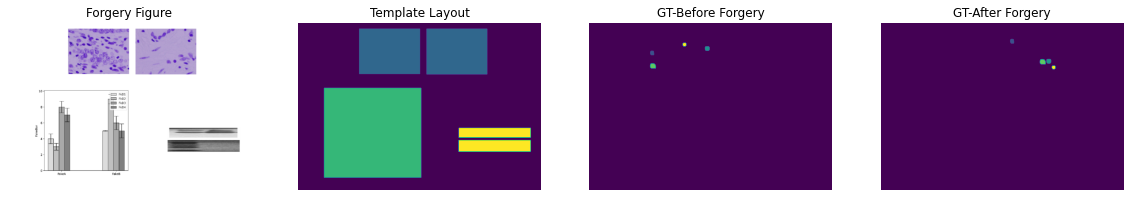

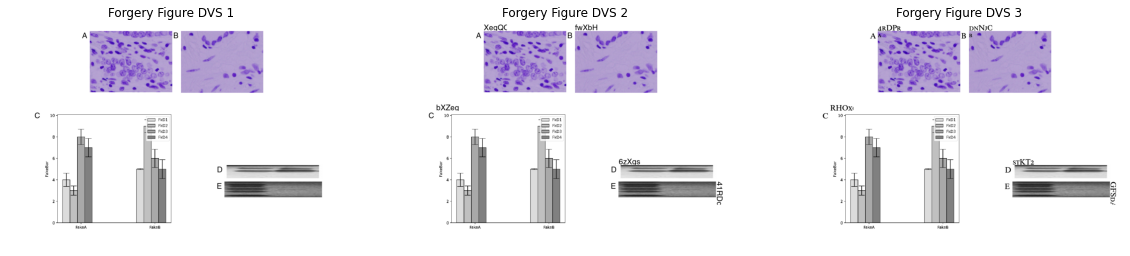

FORGERY METADATA


{'forgery_info': {'class': 'Microscopy',
  'function_name': 'splicing_forgery',
  'args': {'n_objects': 10},
  'figure_type': 'inter-panel',
  'modality': 'duplication'},
 'figure_annotations': {'height': 882,
  'width': 1280,
  'template': '../templates_json/Mix/092_gt.json',
  1: {'bbox': {'x0': 322, 'x1': 643, 'y0': 35, 'y1': 273},
   'class': '__FORGERY__',
   'image_id': '../srcDataset/00052.png'},
  2: {'bbox': {'x0': 677, 'x1': 997, 'y0': 35, 'y1': 275},
   'class': '__PRISTINE__',
   'image_id': '../srcDataset/00009.png'},
  3: {'bbox': {'x0': 137, 'x1': 649, 'y0': 346, 'y1': 817},
   'class': 'Graphs',
   'image_id': 'RANDOM_GRAPH'},
  4: {'bbox': {'x0': 847, 'x1': 1226, 'y0': 556, 'y1': 607},
   'class': 'WesternBlot',
   'image_id': '../srcDataset/01967.jpg'},
  5: {'bbox': {'x0': 846, 'x1': 1226, 'y0': 620, 'y1': 681},
   'class': 'WesternBlot',
   'image_id': '../srcDataset/02000.png'}}}

In [48]:
# Function test
#####################
# Get a splicing pair
donor_id, host_id = splicing_pairs[0]
query_donor = local_dataframe.loc[local_dataframe['dataPath'] == donor_id].iloc[0]
query_host = local_dataframe.loc[local_dataframe['dataPath'] == host_id].iloc[0]

# Loading local dataset withou the pair
local_dataset = get_splicing_local_dataset(splicing_pairs[0])

# Loading forgery info
forgery_info = {
    'function_name' : 'splicing_forgery',
    'args' : {
        'n_objects': 10
             },
    'forgery_class': 'Microscopy'
}

# Apply splicing
tampering = InterPanelForgery(local_dataset, forgery_info, query=None, query_donor=query_donor, query_host=query_host, template_dataset=bio_templates)

# Plot Result
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1); plt.imshow(tampering.figure);plt.title("Forgery Figure");plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(tampering.template_image);plt.title("Template Layout");plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(tampering.gt_after_forgery);plt.title("GT-Before Forgery");plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(tampering.gt_before_forgery);plt.title("GT-After Forgery");plt.axis('off')
plt.show()


plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1); plt.imshow(tampering.apply_verbose_text(tampering.figure, 1,random.choice(fonts)));plt.title("Forgery Figure DVS 1");plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(tampering.apply_verbose_text(tampering.figure, 2,random.choice(fonts)));plt.title("Forgery Figure DVS 2");plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(tampering.apply_verbose_text(tampering.figure, 3,random.choice(fonts)));plt.title("Forgery Figure DVS 3");plt.axis('off')
plt.show()
print("FORGERY METADATA")
tampering.get_forgery_metadata()

# 4 - Retouching on Copy-Move panels

In this section we apply retouching on one of the copied panels to make more difficult to distinguish them

In [49]:
from forgery_lib.retouching import retouching_brightness_contrast, retouching_blurring
from forgery_lib.cleaning import cleaning_using_bf

### Function to apply the retouching techniques

In [50]:
def apply_retouching(image, objs_map, hide_object=False):
    # load image
    img = np.array(Image.open(image))
    objs_map = np.array(Image.open(objs_map).convert('L'))
    
    # Check if we also will apply a cleaning technique
    if hide_object:
        img, _, retouched_objs = cleaning_using_bf(img,objs_map,n_objects=10)
        # Remove retouched objects from the obj_map
        objs_map[retouched_objs>0] =0
    
    img, retouched_objs = retouching_blurring(img, objs_map, n_objects=10,blur_level=1)
    # Remove retouched objects from the obj_map
    objs_map[retouched_objs>0] =0
    img, retouched_objs = retouching_brightness_contrast(img, objs_map, n_objects=10, alpha=[1.1 for i in range(10)],
                                                                   beta=[5 for i in range(10)])
   
    return img


def find_forgery_panel(panels):
    for _, panel in panels.items():
        if panel['class'] == "__FORGERY__":
            return panel

### Function to get a specific dataset for each image, avoiding any contamination

In [51]:
def get_local_dataset(query):
    """
    This function selectes a local dataset for an input image (that will participate the forgery)
    removing it from the real dataset to avoid any contamination during the forgery procedure
    """
    local_dataframe = dataset_dataframe.copy()
    local_dataframe.drop(local_dataframe.loc[local_dataframe['dataPath']==query['dataPath']].index, inplace=True)
    
    bio_data = local_dataframe[ local_dataframe['subset_tag'].isin(['obj_map','gray','color','pmc'])]
    wb_data = local_dataframe[ local_dataframe['subset_tag'].isin(['wblot'])]
  
    return bio_data.append(wb_data)

### Test function

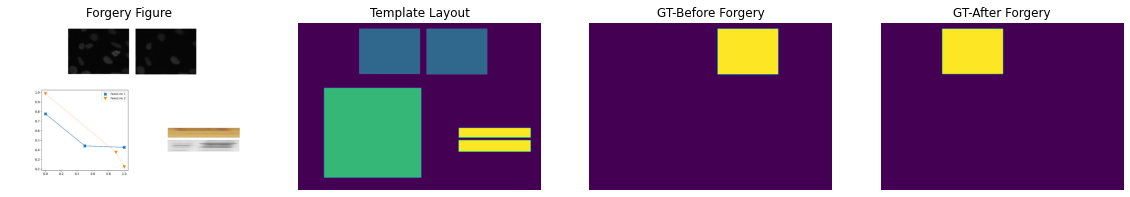

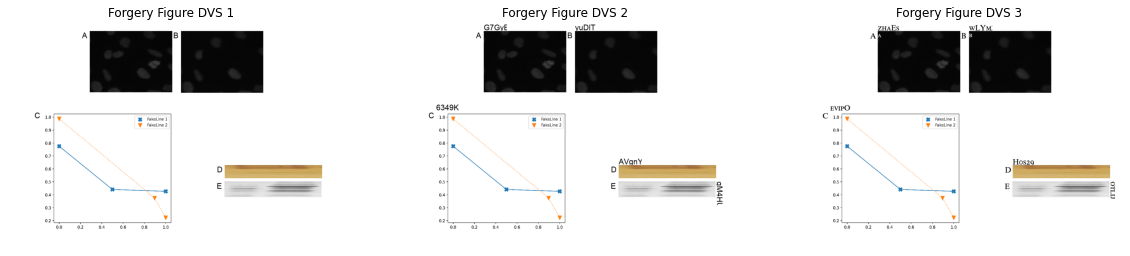

FORGERY METADATA


{'forgery_info': {'class': 'Microscopy',
  'function_name': 'simple_copy',
  'args': {'operations': {'flip': False, 'rotation': None, 'brightness': 9}},
  'figure_type': 'inter-panel',
  'modality': 'duplication',
  'submodality': 'copy-move-with-retouching-and-cleaning'},
 'figure_annotations': {'height': 882,
  'width': 1280,
  'template': '../templates_json/Mix/092_gt.json',
  1: {'bbox': {'x0': 322, 'x1': 643, 'y0': 35, 'y1': 273},
   'class': '__PRISTINE__',
   'image_id': '../srcDataset/00001.png'},
  2: {'bbox': {'x0': 677, 'x1': 997, 'y0': 35, 'y1': 275},
   'class': '__FORGERY__',
   'image_id': '../srcDataset/00001.png'},
  3: {'bbox': {'x0': 137, 'x1': 649, 'y0': 346, 'y1': 817},
   'class': 'Graphs',
   'image_id': 'RANDOM_GRAPH'},
  4: {'bbox': {'x0': 847, 'x1': 1226, 'y0': 556, 'y1': 607},
   'class': 'WesternBlot',
   'image_id': '../srcDataset/01974.tif'},
  5: {'bbox': {'x0': 846, 'x1': 1226, 'y0': 620, 'y1': 681},
   'class': 'WesternBlot',
   'image_id': '../srcDatas

In [56]:
# Function test
#####################
# Load all images in the dataset that has an object map
bio_data_with_groundtruth = dataset_dataframe[ dataset_dataframe['subset_tag'].isin(['obj_map','gray','color'])]
# select a query
query = bio_data_with_groundtruth.iloc[0]

# Get a local_dataset that have ours contrains
local_dataset = get_local_dataset(query)
# Loading info
forgery_info = {
                'function_name' : 'simple_copy',
                'args' : {'operations': { 'flip':False,
                                          'rotation': None,
                                          'brightness' : randint(0,20) 
                                         }
                         },
                'forgery_class': 'Microscopy'
                }






# Apply function with at most 10 objects cleaned
tampering = InterPanelForgery(local_dataset, forgery_info, query, template_dataset=bio_templates)

# Apply retouch
forgery_panel = find_forgery_panel(tampering.panels)
retouched_panel_img = apply_retouching(query['dataPath'], query['dataGTPath'], True)
forgery_panel['associated_img'] = retouched_panel_img 
tampering.figure = tampering.insert_panel_in_figure(tampering.figure, retouched_panel_img, forgery_panel['bbox'])
tampering.forgery_image = retouched_panel_img

# Plot Result
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1); plt.imshow(tampering.figure);plt.title("Forgery Figure");plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(tampering.template_image);plt.title("Template Layout");plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(tampering.gt_after_forgery);plt.title("GT-Before Forgery");plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(tampering.gt_before_forgery);plt.title("GT-After Forgery");plt.axis('off')
plt.show()


plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1); plt.imshow(tampering.apply_verbose_text(tampering.figure, 1,random.choice(fonts)));plt.title("Forgery Figure DVS 1");plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(tampering.apply_verbose_text(tampering.figure, 2,random.choice(fonts)));plt.title("Forgery Figure DVS 2");plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(tampering.apply_verbose_text(tampering.figure, 3,random.choice(fonts)));plt.title("Forgery Figure DVS 3");plt.axis('off')
plt.show()
print("FORGERY METADATA")
metadata = tampering.get_forgery_metadata()
metadata['forgery_info']['submodality'] = 'copy-move-with-retouching-and-cleaning'
metadata